## 遠方銀河「BR1202 [CII] 輝線データ」

ここで使用するデータは、ALMA Band 7で観測された遠方銀河「BR1202」の[CII]輝線キューブイメージデータです。
<br>
<a href="https://almascience.nao.ac.jp/alma-data/science-verification" target="_blank" rel="noopener">Science Verification Data</a>の一つとして取得されたデータ（「6. BR1202-0725 Band 7」を参照）から作成されたイメージを使用します。
また、初期解析についてはCASAガイドも参考になります（CASA Guide : <a href="https://casaguides.nrao.edu/index.php?title=File:BR1202_SV_Band7_Calibration_notes.pdf" target="_blank" rel="noopener">BR1202 SV Band7 Calibration notes</a>）。

JVOのサイトからもイメージFITSを直接ダウンロードできます。<br>
- Dataset Information :
    https://jvo.nao.ac.jp/portal/alma/sv.do?action=dataset.info&datasetId=ALMA00000012 <br>
- FITS link :
    <a href="http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA00000012_00_00_00" download>ALMA00000012_00_00_00.fits</a> <br>

また、連続波イメージのデータについても、JVOのサイトからもイメージFITSを直接ダウンロードできます。<br>
- Dataset Information :
    https://jvo.nao.ac.jp/portal/alma/sv.do?action=dataset.info&datasetId=ALMA00000011 <br>
- FITS link :
    <a href="http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA00000011_00_00_00" download>ALMA00000011_00_00_00.fits</a>

### モジュールの読み込み（インストール）

最初に、Google Colab環境の場合、CASAモジュールをインストールしてCASA実行環境を構築する処理を行っています。

In [1]:
import sys, os
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [2]:
# For Google Colaboratory（Google Colab環境か判別し、Google Colab環境ならCASA実行環境を構築）
print(type(sys.modules))
moduleList = sys.modules
ENV_COLAB = False

if 'google.colab' in moduleList:
    print("google_colab")
    ENV_COLAB = True
else:
    print("Not google_colab")

if ENV_COLAB:
    print("Execute in google_colab")
#    print("installing pre-requisite packages...\n")

    print("installing casa packages...\n")
    !pip install casatools==6.6.0.20 # should install version 6.6.0 or later for Google Colab (python 3.10)
    !pip install casatasks==6.6.0.20
#    !pip install casatools
#    !pip install casatasks
    !pip install casadata

    print("make a config file for Google Colab...\n")
    !mkdir ~/.casa
    !echo "home     = '/content/'" > ~/.casa/config.py
    !echo "datapath = ['`find / -type d -name casadata`']" >> ~/.casa/config.py
    !more ~/.casa/config.py
    print("Completion of CASA preparation")

<class 'dict'>
google_colab
Execute in google_colab
installing casa packages...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 MB 1.4 MB/s eta 0:00:00
make a config file for Google Colab...

find: ‘/proc/56/task/56/net’: Invalid argument
find: ‘/proc/56/net’: Invalid argument
home     = '/content/'
datapath = ['/usr/local/lib/python3.10/dist-packages/casadata']
Completion of CASA preparation


In [3]:
import casatools
import casatasks

以下では必要なモジュールを読み込んでいます。<br>
ローカル環境で実行する場合は、以下で読み込んでいるモジュール及びCASAモジュールをあらかじめインストールしてから実行して下さい。

In [4]:
#import sys, os
import urllib.request
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit

### JVOよりイメージFITSデータのダウンロード

In [5]:
# cube image for line
url = 'http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA00000012_00_00_00'
orgimfits='ALMA00000012_00_00_00.fits'
orgimgdat='BR1202_line_cube.image'
myimages ='BR1202_line_cube.subimage'
# continuum image
urlct = 'http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA00000011_00_00_00'
orgimfitsct='ALMA00000011_00_00_00.fits'
orgimgdatct='BR1202_cont.image'
myimagesct ='BR1202_cont.subimage'

"url", "orgimfits"ではダウンロードするイメージFITSのURLとファイル名を指定しています。<br>
ダウンロードされたFITSをCASAで読み込んだイメージファイル名を"orgimgdat"で、扱いやすい様に切り出したイメージファイル名を"myimages"で指定し、このスクリプト内で使用するイメージファイルの基本名として以後共通で使用します。<br>
また、連続波イメージについては、上記パラメータそれぞれの後ろに"ct"が付いています。

In [6]:
# cube image
if not (os.path.isfile(orgimfits)):
    print(f"downloading fits file.:  {orgimfits}")
    urllib.request.urlretrieve(url, orgimfits)
    print("finish download.")
else:
    print("fits file already exist.")

downloading fits file.:  ALMA00000012_00_00_00.fits
finish download.


In [7]:
# continuum image
if not (os.path.isfile(orgimfitsct)):
    print(f"downloading fits file.:  {orgimfitsct}")
    urllib.request.urlretrieve(urlct, orgimfitsct)
    print("finish download.")
else:
    print("fits file already exist.")

downloading fits file.:  ALMA00000011_00_00_00.fits
finish download.


先に設定したURLからFITSをダウンロードします。既にFITSファイルが存在する場合はスキップします。

In [8]:
!ls -lh ALMA00000012*.fits ALMA00000011*.fits

-rw-r--r-- 1 root root 330K Jan 10 04:34 ALMA00000011_00_00_00.fits
-rw-r--r-- 1 root root  33M Jan 10 04:34 ALMA00000012_00_00_00.fits


ダウンロードしたFITSファイルを確認しています。先頭に"!"を付けるとシェルコマンドが実行可能。

### イメージFITS読み込み

In [9]:
from casatasks import importfits
# cube image
os.system('rm -rf '+orgimgdat)
importfits(fitsimage=orgimfits, imagename=orgimgdat, overwrite=True)
# continuum image
os.system('rm -rf '+orgimgdatct)
importfits(fitsimage=orgimfitsct, imagename=orgimgdatct, overwrite=True)

タスク<code><font color='red'>importfits</font></code>でイメージFITSをCASA形式のイメージファイルに変換します。<br>
パラメータ<code>fitsimage</code>には入力イメージFITS名を、<code>imagename</code>には出力されるCASA形式のファイル名（実体はディレクトリ）を指定します。それぞれ先に定義したファイル名を引用しています。

### ヘッダーの確認

In [10]:
from casatasks import imhead
# cube image
imname = orgimgdat
imhd_A1 = imhead(imname)

print(imhd_A1['axisnames'])
print(imhd_A1['axisunits'])
print(imhd_A1['shape'])
#print(imhd_A1['incr'])
pixinc=imhd_A1['incr'][0:2]
if imhd_A1['axisunits'][0]=='rad': pixinc=pixinc*180/np.pi
print('ref. freq. :', imhd_A1['refval'][2]/10**9, 'GHz')
print('pixel incr.:', pixinc*3600, 'arcsec/pixel')
print('ch width   :', abs(imhd_A1['incr'][2])/10**6, 'MHz/pixel')

['Right Ascension' 'Declination' 'Frequency' 'Stokes']
['rad' 'rad' 'Hz' '']
[256 256 128   1]
ref. freq. : 334.9602625 GHz
pixel incr.: [-0.25  0.25] arcsec/pixel
ch width   : 15.625 MHz/pixel


In [11]:
# continuum image
imname = orgimgdatct
imhd_B1 = imhead(imname)

print(imhd_B1['axisnames'])
print(imhd_B1['axisunits'])
print(imhd_B1['shape'])
#print(imhd_B1['incr'])
pixinc=imhd_B1['incr'][0:2]
if imhd_B1['axisunits'][0]=='rad': pixinc=pixinc*180/np.pi
print('ref. freq. :', imhd_B1['refval'][2]/10**9, 'GHz')
print('pixel incr.:', pixinc*3600, 'arcsec/pixel')

['Right Ascension' 'Declination' 'Frequency' 'Stokes']
['rad' 'rad' 'Hz' '']
[256 256   1   1]
ref. freq. : 341.9 GHz
pixel incr.: [-0.25  0.25] arcsec/pixel


タスク<code><font color='red'>imhead</font></code>を使ってイメージデータのヘッダーから各軸の基本情報を取得して表示しています。
ヘッダー情報はPythonの辞書オブジェクトとして読み込まれ、keywordを指定して呼び出すことが出来ます。<br>
上記では、各軸の'axisnames'（軸の名前）・'axisunits'（単位）・'shape'（ピクセル数）を表示し、参照周波数（ref. freq.; 大体の観測周波数が分かる）・空間方向のピクセル間隔（pixel incr.）・周波数方向のピクセル間隔（ch width; キューブイメージのみ）も出力しています。
単位にも注意してください（空間方向の単位がラジアン "radian" 場合、度 "degree" に変換する必要があります）。

### FITSイメージ表示

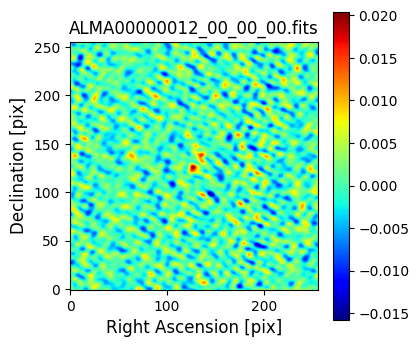

In [12]:
chan=70
ff,aa=plt.subplots(1,1, figsize=(4,4))
im=aa.imshow(fits.getdata(orgimfits)[0,chan,:,:], origin='lower', cmap='jet')
cbar=plt.colorbar(im, ax=aa)
aa.set_title(orgimfits)
aa.set_xlabel(imhd_A1['axisnames'][0]+" [pix]",size=12)
aa.set_ylabel(imhd_A1['axisnames'][1]+" [pix]",size=12)
plt.show()

キューブ（ライン）イメージについて、試しに周波数方向の70チャンネル目のチャンネルイメージを表示しています（FITSファイルを直接読み出して表示）。
表示する周波数チャンネルは"chan"で変更可能です。
（イメージFITSと読み込まれたCASA形式のイメージファイルでは軸の順番が異なる可能性がある事に注意してください）

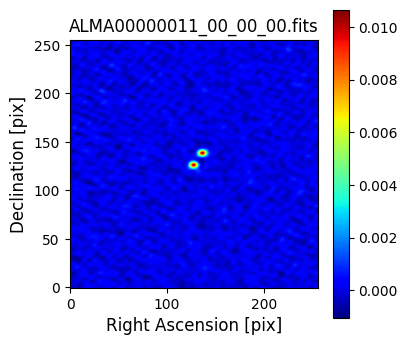

In [13]:
ff,aa=plt.subplots(1,1, figsize=(4,4))
im=aa.imshow(fits.getdata(orgimfitsct)[0,0,:,:], origin='lower', cmap='jet')
cbar=plt.colorbar(im, ax=aa)
aa.set_title(orgimfitsct)
aa.set_xlabel(imhd_B1['axisnames'][0]+" [pix]",size=12)
aa.set_ylabel(imhd_B1['axisnames'][1]+" [pix]",size=12)
plt.show()

こちらは連続波イメージを表示しています。

### ヘッダーから合成ビームサイズを確認

In [14]:
from casatasks import imhead
for imname in [orgimgdat, orgimgdatct]:
    bmaj  =imhead(imname, mode='get', hdkey='beammajor')['value']
    bmajut=imhead(imname, mode='get', hdkey='beammajor')['unit']
    bmin  =imhead(imname, mode='get', hdkey='beamminor')['value']
    bminut=imhead(imname, mode='get', hdkey='beamminor')['unit']
    bmpa  =imhead(imname, mode='get', hdkey='beampa')['value']
    bmpaut=imhead(imname, mode='get', hdkey='beampa')['unit']
    if bmpaut=='rad': bmpa=bmpa*180/math.pi; bmpaut='deg'
    print('Synthesized Beam of '+imname+':')
    print(f'   Major Axis = {bmaj:.7f} {bmajut}')
    print(f'   Minor Axis = {bmin:.7f} {bminut}')
    print(f'   Pos. Angle = {bmpa:.7f} {bmpaut}')

Synthesized Beam of BR1202_line_cube.image:
   Major Axis = 1.7564977 arcsec
   Minor Axis = 1.3982995 arcsec
   Pos. Angle = 87.3220291 deg
Synthesized Beam of BR1202_cont.image:
   Major Axis = 1.7226058 arcsec
   Minor Axis = 1.3101563 arcsec
   Pos. Angle = -86.6755066 deg


タスク<code><font color='red'>imhead</font></code>で、イメージデータのヘッダーから合成ビームサイズを読み取り表示しています。

### イメージRMSを確認

In [15]:
from casatasks import imhead
from casatasks import imstat
# cube image
imname = orgimgdat
imhd_A = imhead(imname)
radipx = 100 # pixel
cetpx = [str(int((imhd_A['shape'][0]-1)/2)), str(int((imhd_A['shape'][1]-1)/2))]
ofpx = 10 ; wdpx = 10
nchan = imhd_A['shape'][2]
stats1=imstat(imagename=imname,
      region='circle[['+cetpx[0]+'pix,'+cetpx[1]+'pix],'+str(radipx)+'pix],\
      range=['+str(ofpx)+'pix,'+str(ofpx+wdpx-1)+'pix]')
stats2=imstat(imagename=imname,
      region='circle[['+cetpx[0]+'pix,'+cetpx[1]+'pix],'+str(radipx)+'pix],\
      range=['+str(nchan-ofpx-wdpx)+'pix,'+str(nchan-ofpx-1)+'pix]')
stats3=imstat(imagename=imname,
      region='circle[['+cetpx[0]+'pix,'+cetpx[1]+'pix],'+str(radipx)+'pix],\
      range=['+str(ofpx+wdpx)+'pix,'+str(nchan-ofpx-wdpx-1)+'pix]')
imgrms=(stats1['rms'][0]+stats2['rms'][0])/2.0
imgpek=stats3['max'][0]
print(f'RMS of {imname}: {imgrms*1000:.7f} [mJy/beam]')
print(f'Peak of {imname}: {imgpek*1000:.7f} [mJy/beam]')

RMS of BR1202_line_cube.image: 3.5801296 [mJy/beam]
Peak of BR1202_line_cube.image: 24.2306907 [mJy/beam]


タスク<code><font color='red'>imstat</font></code>で、パラメータ<code>region</code>で指定された空間・周波数範囲内のピクセル値から、イメージRMSやピーク値などの統計量を計算しています。<br>
領域<code>region</code>として、"<code>circle</code>" で円形の空間領域を、"<code>range</code>"で周波数(速度)方向の範囲を指定しています。
イメージRMS（ノイズの大きさ）を測るときは、天体からの放射のない（emission free）領域で測定する必要があります。
従って "<code>range</code>" では輝線の検出されていない周波数チャンネルを指定してRMSを求めます。
<br>
上記スクリプトにおいて、"<code>circle</code>" でイメージ中央を中心に半径 "radipx" ピクセルの円形で囲まれる空間領域（半径 100pix）が指定されています。
"<code>range</code>" では両周波数端から "ofpx" ピクセルを除いて "wdpx" ピクセル幅の範囲をemission freeと想定して、両周波数端周辺で算出して平均しています（10pix～19pix及び108pix～117pix）。
一方、ピーク値はRMSを測定した周波数範囲の内側で測定しています（20pix～107pix）。
<br><br>
領域<code>region</code>の指定方法については、詳しくは以下をご覧ください。
<p style="padding-left:2em">
CASA Docs : <a href="https://casadocs.readthedocs.io/en/stable/notebooks/image_analysis.html#Region-File-Format" target="_blank" rel="noopener">Region File Format</a>
</p>

In [16]:
# continuum image
imname = orgimgdatct
imhd_B = imhead(imname)
inrdipx = 30 # pixel; inner radius
otrdipx = 100 # pixel; outer radius
cetpx = [str(int((imhd_B['shape'][0]-1)/2)), str(int((imhd_B['shape'][1]-1)/2))]
stats1=imstat(imagename=imname,
      region='annulus[['+cetpx[0]+'pix,'+cetpx[1]+'pix],['+str(inrdipx)+'pix,'+str(otrdipx)+'pix]]')
stats2=imstat(imagename=imname,
      region='circle[['+cetpx[0]+'pix,'+cetpx[1]+'pix],'+str(inrdipx)+'pix]')
imgrmsct=stats1['rms'][0]
imgpekct=stats2['max'][0]
print(f'RMS of {imname}: {imgrmsct*1000:.7f} [mJy/beam]')
print(f'Peak of {imname}: {imgpekct*1000:.7f} [mJy/beam]')

RMS of BR1202_cont.image: 0.2586689 [mJy/beam]
Peak of BR1202_cont.image: 10.6590521 [mJy/beam]


こちらは連続波イメージのイメージRMS及びピーク値です。<br>
イメージRMS測定では、中央の付近の連続波放射を避けるため、領域<code>region</code>として "<code>annulus</code>" によりイメージ中央を中心に半径 "inrdipx" ピクセルから半径 "otrdipx" ピクセルの間のリング状の領域を指定して（半径30pix～半径100pix）、その範囲でイメージRMSを求めています。

### サブイメージ作成

In [17]:
from casatasks import imsubimage
from casatasks import exportfits
sbxywd = 80 # pixels; subimage width in X/Y
# cube image
imhd_A = imhead(orgimgdat)
cetpx = [str(int((imhd_A['shape'][0]-1)/2)), str(int((imhd_A['shape'][1]-1)/2))]
os.system('rm -rf '+myimages)
imsubimage(imagename=orgimgdat, outfile=myimages, dropdeg=True,
           region='centerbox[['+cetpx[0]+'pix,'+cetpx[1]+'pix],['+str(sbxywd)+'pix,'+str(sbxywd)+'pix]]')
exportfits(imagename=myimages, fitsimage=myimages+'.fits',
           dropdeg=True, dropstokes=True, overwrite=True)
# continuum image
imhd_B = imhead(orgimgdatct)
cetpx = [str(int((imhd_B['shape'][0]-1)/2)), str(int((imhd_B['shape'][1]-1)/2))]
os.system('rm -rf '+myimagesct)
imsubimage(imagename=orgimgdatct, outfile=myimagesct, dropdeg=True,
           region='centerbox[['+cetpx[0]+'pix,'+cetpx[1]+'pix],['+str(sbxywd)+'pix,'+str(sbxywd)+'pix]]')
exportfits(imagename=myimagesct, fitsimage=myimagesct+'.fits',
           dropdeg=True, dropstokes=True, overwrite=True)

先にイメージを試験的に表示させた結果から、天体の放射成分があるのはイメージ中心付近のみであることが分かりました。
そこでデータを扱いやすくするために、タスク <code style="color: #ff0000;">imsubimage</code>で天体成分のあるイメージ中心付近について切り出すことにします。
上記では、イメージ中央を中心に一辺 "sbxywd" ピクセルの正方形領域を切り出しています（領域<code>region</code>指定に"<code>centerbox</code>"を使用：上記では 80pix &times; 80pixの領域）。

### スペクトルの表示

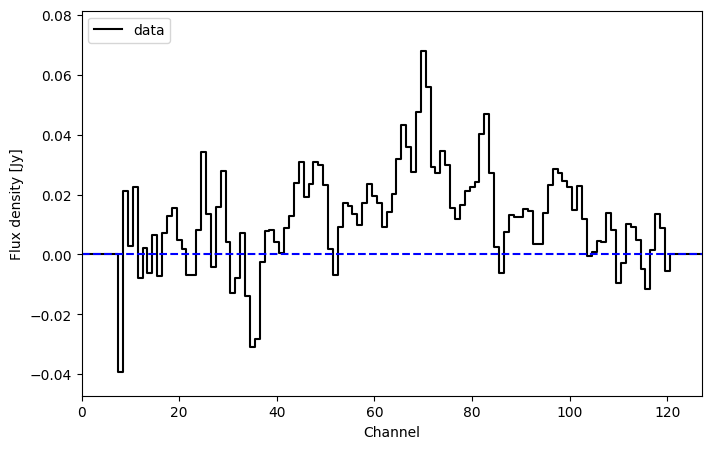

In [18]:
from casatasks import imhead
from casatasks import specflux
imname = myimages
splogf0 = imname+'.spec.log'
imhd_Asub = imhead(imname)
xspwd = 35 ; yspwd = 35 # pixels
cetpx = [str(int((imhd_Asub['shape'][0]-1)/2)), str(int((imhd_Asub['shape'][1]-1)/2))]
specflux(imagename=imname,
     region='centerbox[['+cetpx[0]+'pix,'+cetpx[1]+'pix],['+str(xspwd)+'pix,'+str(yspwd)+'pix]]',
     function='flux density', unit='km/s',
     logfile=splogf0, overwrite=True)
dt_ax,dt_npx,dt_frq,dt_vl,dt_fl = np.loadtxt(splogf0, comments='#', unpack=True)

imgview=0 # yaxis selection: 0=channel, 1=frequency
ymin = min(dt_fl); ymax = max(dt_fl)
ff, aa = plt.subplots(1,1, figsize=(8,5))
if imgview == 0:
    xmin = min(dt_ax); xmax = max(dt_ax)
    imr = aa.step(dt_ax, dt_fl, color="k", label="data", where="mid")
    aa.set_xlim(xmin, xmax)  ; aa.set_xlabel("Channel")
elif imgview == 1:
    xmin = min(dt_frq); xmax = max(dt_frq)
    imr = aa.step(dt_frq, dt_fl, color="k", label="data", where="mid")
    aa.set_xlim(xmin, xmax)  ; aa.set_xlabel("Frequency [MHz]")
aa.set_ylim(ymin*1.2, ymax*1.2) ; aa.set_ylabel("Flux density [Jy]")
plt.hlines([0], xmin, xmax, "blue", linestyles='dashed')
aa.legend(loc="upper left")
plt.show()

スペクトル線データから作成される3次元のキューブイメージにおいて、一部の領域内のピクセル値を空間方向に足し合わせる（又は平均する）事で、周波数方向のスペクトルを作成する事が出来ます。<br>
ここではキューブイメージからタスク<code><font color='red'>specflux</font></code>で領域<code>region</code>の指定範囲内でスペクトルを作成し表示しています。
上記では、領域としてイメージ中央を中心に "xspwd" ピクセル &times; "yspwd" ピクセル の四角形に切り出して（上記では 35pix &times; 35pix）、合成ビームサイズを考慮して足し合わせたスペクトル（縦軸（強度スケール）はFlux density \[Jy\]）を作成しています。<br>
タスク<code><font color='red'>specflux</font></code>は作成されたスペクトルデータをバラメータ<code>logfile</code>で指定されたファイルへ書き出し、これをもとにPythonのmatplotlibモジュールでスペクトル図を描画します。
また、"imgview" で横軸をチャンネル又は周波数に切り替える事が出来る様にしています。

### モーメントマップ作成

In [19]:
from casatasks import immoments
from casatasks import exportfits
imname = myimages
imname_m0 = imname+'.m0'
imname_m1 = imname+'.m1'
imname_m2 = imname+'.m2'
imname_m8 = imname+'.m8'
imname_lt = [imname_m0, imname_m8, imname_m1, imname_m2]
cutrms = 3.0     # intensity cut off for moment1 & moment2
mochs = [25, 112]  # channel ranges for moment maps
os.system('rm -rf '+imname+'.m*')
# moment0 & moment8
immoments(imagename = imname, outfile = imname_m0, moments = 0,
       axis = 'spectral', chans=str(mochs[0])+'~'+str(mochs[1]))
immoments(imagename = imname, outfile = imname_m8, moments = 8,
       axis = 'spectral', chans=str(mochs[0])+'~'+str(mochs[1]))
# moment1 & moment2
immoments(imagename = imname, outfile = imname_m1, moments = 1,
       axis = 'spectral', chans=str(mochs[0])+'~'+str(mochs[1]),
       includepix=[imgrms*cutrms, 9999.])
immoments(imagename = imname, outfile = imname_m2, moments = 2,
       axis = 'spectral', chans=str(mochs[0])+'~'+str(mochs[1]),
       includepix=[imgrms*cutrms, 9999.])
# fits
for name in imname_lt:
    exportfits(imagename=name, fitsimage=name+'.fits',
               dropdeg=True, dropstokes=True, overwrite=True)
print('moment maps have been made.')

moment maps have been made.


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'.


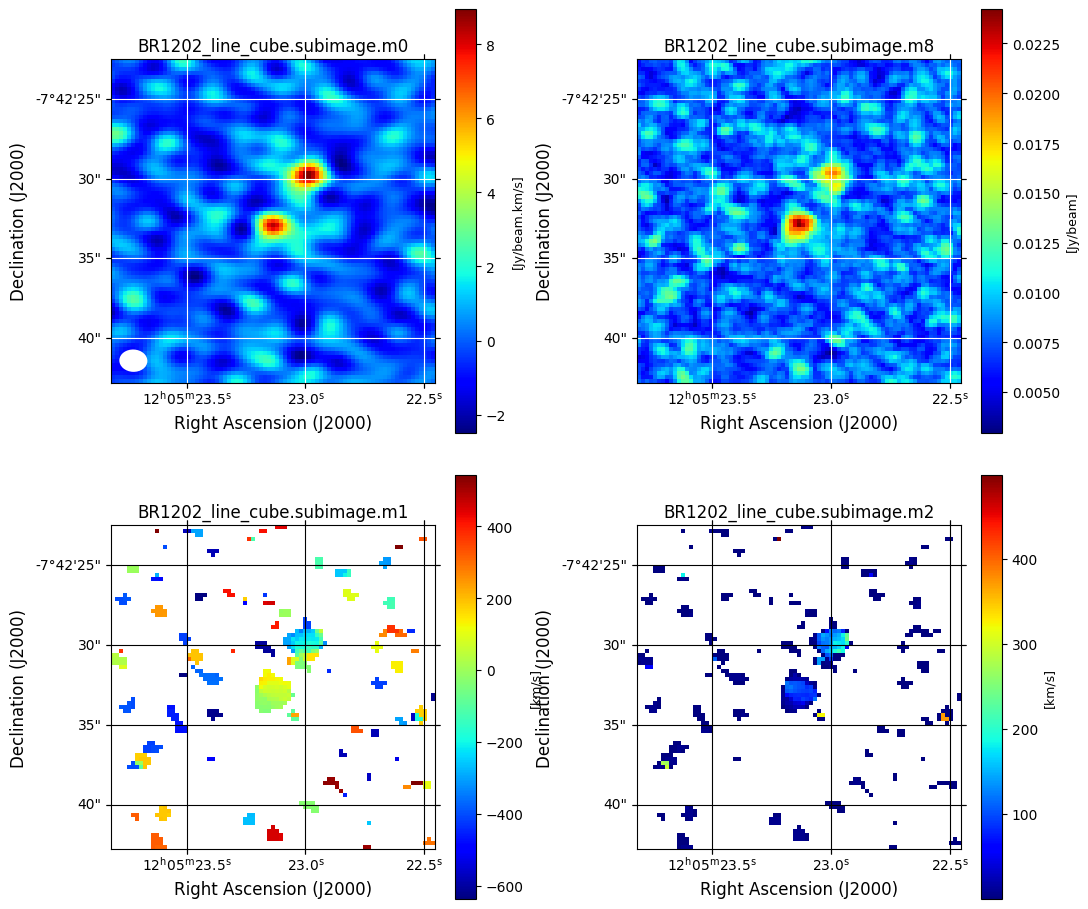

In [20]:
ftdata_0 = fits.open(imname_m0+'.fits')
ft_dat_0 = ftdata_0[0].data
wmap_0 = WCS(ftdata_0[0].header)
unit_0 = "["+ftdata_0[0].header['BUNIT']+"]"
ftdata_0.close()

axivl = imhead(imname_m0, mode='get', hdkey='cdelt1')['value']*3600
axiut = imhead(imname_m0, mode='get', hdkey='cdelt1')['unit']
if axiut=='rad': axivl=axivl*180/math.pi
bmaj0  =imhead(imname_m0, mode='get', hdkey='beammajor')['value']
bmin0  =imhead(imname_m0, mode='get', hdkey='beamminor')['value']
bmpa0  =imhead(imname_m0, mode='get', hdkey='beampa')['value']
bmpaut0=imhead(imname_m0, mode='get', hdkey='beampa')['unit']
if bmpaut0=='rad': bmpa0=bmpa0*180/math.pi

ftdata_8 = fits.open(imname_m8+'.fits')
ft_dat_8 = ftdata_8[0].data
wmap_8 = WCS(ftdata_8[0].header)
unit_8 = "["+ftdata_8[0].header['BUNIT']+"]"
ftdata_8.close()

ftdata_1 = fits.open(imname_m1+'.fits')
ft_dat_1 = ftdata_1[0].data
wmap_1 = WCS(ftdata_1[0].header)
unit_1 = "["+ftdata_1[0].header['BUNIT']+"]"
ftdata_1.close()

ftdata_2 = fits.open(imname_m2+'.fits')
ft_dat_2 = ftdata_2[0].data
wmap_2 = WCS(ftdata_2[0].header)
unit_2 = "["+ftdata_2[0].header['BUNIT']+"]"
ftdata_2.close()

fig = plt.figure(figsize=(12,10))
plt.subplots_adjust(top=1.0, wspace=0.3, hspace=0.1)

ax = plt.subplot(221, projection=wmap_0)
plt.imshow(ft_dat_0, origin='lower', cmap='jet')
cbar=plt.colorbar()
cbar.set_label(unit_0, size=9)
plt.title(imname_m0)
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension (J2000)', size=12)
plt.ylabel('Declination (J2000)', size=12)
d = patches.Ellipse(xy=(5, 5), width=bmin0/axivl, height=bmaj0/axivl, angle=bmpa0,
                    fill=True, fc="w")
ax.add_patch(d)

ax = plt.subplot(222, projection=wmap_8)
plt.imshow(ft_dat_8, origin='lower', cmap='jet')
cbar=plt.colorbar()
cbar.set_label(unit_8, size=9)
plt.title(imname_m8)
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension (J2000)', size=12)
plt.ylabel('Declination (J2000)', size=12)

ax = plt.subplot(223, projection=wmap_1)
plt.imshow(ft_dat_1, origin='lower', cmap='jet')
cbar=plt.colorbar()
cbar.set_label(unit_1, size=9)
plt.title(imname_m1)
plt.grid(color='black', ls='solid')
plt.xlabel('Right Ascension (J2000)', size=12)
plt.ylabel('Declination (J2000)', size=12)

ax = plt.subplot(224, projection=wmap_2)
plt.imshow(ft_dat_2, origin='lower', cmap='jet')
cbar=plt.colorbar()
cbar.set_label(unit_2, size=9)
plt.title(imname_m2)
plt.grid(color='black', ls='solid')
plt.xlabel('Right Ascension (J2000)' ,size=12)
plt.ylabel('Declination (J2000)', size=12)

plt.savefig('BR1202_line_moment_maps_wcs.png', bbox_inches="tight", pad_inches=0.05)

スペクトル線データから作成されるイメージは2つの空間軸と1つの周波数(又は速度)軸からなる3次元のイメージキューブになり、タスク<code><font color='red'>immoments</font></code>によりこれらの3つのイメージ平面を操作してモーメントマップが作成できます。<br>
ここで作成したモーメントマップは、moment 0は積分強度マップ、moment 1は速度場マップ、moment 2は速度分散マップ、moment 8はピーク強度マップに相当します。
<br>
モーメントマップは、上記では"mochs"で指定した周波数チャンネル範囲（上記では25~112チャンネル）で作成されます。また、モーメント1及びモーメント2マップについてはノイズの影響を避けるため、ある閾値 "cutrms" &#x3C3;（上記では3.0 &#x3C3;）以上のデータのみを使って作成しています（イメージRMSは先に測定した値を引用）。
<br>
また、モーメント0マップの左下の楕円は合成ビームサイズを示しています。
<br><br>
モーメントマップについては、詳しくは以下を参考にして下さい。
- CASA Docs :
<a href="https://casadocs.readthedocs.io/en/stable/notebooks/image_analysis.html#Spectral-Analysis" target="_blank" rel="noopener">Spectral Analysis</a> - Computing the Moments of an Image Cube
- CASA Toolkit Reference Manual :
<a href="https://casa.nrao.edu/docs/CasaRef/image.moments.html" target="_blank" rel="noopener">image.moments - Function</a>

### 連続波イメージとの比較

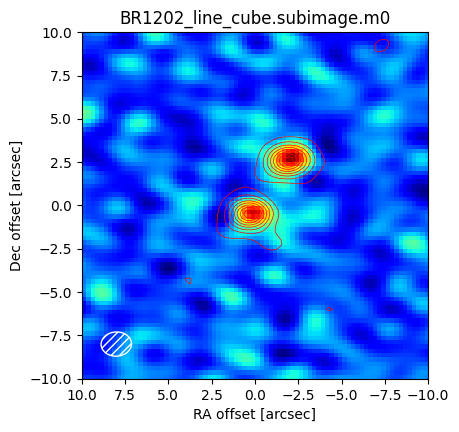

In [21]:
thrd = imgrmsct*2.5
cinc = imgrmsct*5.
levels=[thrd,thrd+cinc*1.0,thrd+cinc*2.0,thrd+cinc*3.0,thrd+cinc*4.0,thrd+cinc*5.0,
        thrd+cinc*6.0,thrd+cinc*7.0,thrd+cinc*8.0,thrd+cinc*9.0,thrd+cinc*10.0,
        thrd+cinc*11.0,thrd+cinc*12.0,thrd+cinc*13.0,thrd+cinc*14.0,thrd+cinc*15.0]
colors = 'red'

imname = myimages
imname_m0 = imname+'.m0'
ftdata = fits.open(imname_m0+'.fits')
ft_hdr = ftdata[0].header
ftdata.close()

bmaj0  =imhead(imname_m0, mode='get', hdkey='beammajor')['value']
bmin0  =imhead(imname_m0, mode='get', hdkey='beamminor')['value']
bmpa0  =imhead(imname_m0, mode='get', hdkey='beampa')['value']
bmpaut0=imhead(imname_m0, mode='get', hdkey='beampa')['unit']
if bmpaut0=='rad': bmpa0=bmpa0*180/math.pi

hsbxywd = ft_hdr['NAXIS1']/2
ft_hdr['CRVAL1'] = 0.0                   ; ft_hdr['CRVAL2'] = 0.0
ft_hdr['CRPIX1'] = hsbxywd+0.5           ; ft_hdr['CRPIX2'] = hsbxywd+0.5
ft_hdr['CDELT1'] = ft_hdr['CDELT1']*3600 ; ft_hdr['CDELT2'] = ft_hdr['CDELT2']*3600

blcx=int(ft_hdr['CRPIX1']-int(hsbxywd)) ; trcx=int(ft_hdr['CRPIX1']+int(hsbxywd))
blcy=int(ft_hdr['CRPIX2']-int(hsbxywd)) ; trcy=int(ft_hdr['CRPIX2']+int(hsbxywd))

ofx_st=(ft_hdr['CRVAL1']+( blcx -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofx_ed=(ft_hdr['CRVAL1']+( trcx -ft_hdr['CRPIX1'])*ft_hdr['CDELT1'])
ofy_st=(ft_hdr['CRVAL2']+( blcy -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])
ofy_ed=(ft_hdr['CRVAL2']+( trcy -ft_hdr['CRPIX2'])*ft_hdr['CDELT2'])

# raster image for line moment0
ff, aa = plt.subplots(1,1, figsize=(8,4.5))
imr = aa.imshow(fits.getdata(imname_m0+'.fits')[blcx:trcx,blcy:trcy],
                extent=(ofx_st,ofx_ed,ofy_st,ofy_ed), origin='lower', cmap='jet')
aa.set_title(imname_m0)
aa.set_xlim(ofx_st,ofx_ed) ; aa.set_ylim(ofy_st,ofy_ed)
aa.set_xlabel("RA offset [arcsec]") ; aa.set_ylabel("Dec offset [arcsec]")
# contour image for continuum
fits_img = fits.getdata(myimagesct+'.fits')[blcx:trcx,blcy:trcy]
xcont = np.arange(ofx_st, ofx_ed, (ofx_ed - ofx_st)/(ft_hdr['NAXIS1']-1) )
ycont = np.arange(ofy_st, ofy_ed, (ofy_ed - ofy_st)/(ft_hdr['NAXIS2']-1) )
imc = aa.contour(xcont, ycont, fits_img, levels=levels,
                 colors=colors, linewidths=0.5)
d = patches.Ellipse(xy=(ofx_st-2,ofy_st+2), width=bmin0, height=bmaj0, angle=bmpa0,
                    fill=False, ec="w", hatch='////', lw = 1)
aa.add_patch(d)
plt.savefig('BR1202_linem0_cont_image.png', bbox_inches="tight", pad_inches=0.05)
plt.show()

カラーのモーメント0マップ（積分強度マップ）に連続波イメージをコントアで重ねています。<br>
連続波イメージのコントアは、2.5 &#x3C3;以上で5 &#x3C3;間隔で描かれています。<br>
また、左下の楕円は輝線キューブイメージの合成ビームサイズを示しています。

### ピーク位置と輝線フラックスの算出

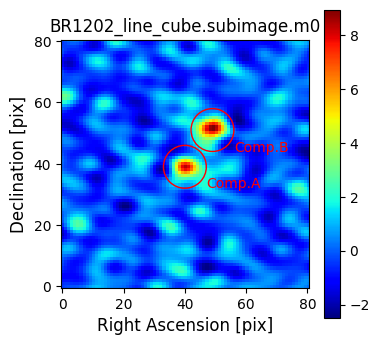

In [22]:
from casatasks import imhead
imname = myimages
imname_m0 = imname+'.m0'
imhd_Csub = imhead(imname_m0)
ff,aa=plt.subplots(1,1, figsize=(4,4))
im=aa.imshow(fits.getdata(imname_m0+'.fits')[:,:], origin='lower', cmap='jet')
radi=7 # radius of region
acent=[40, 39] # center position for Comp.A
bcent=[49, 51] # center position for Comp.B
a = patches.Circle(xy=acent, radius=radi, ec='r', fill=False)
aa.add_patch(a)
aa.text(acent[0]+radi, acent[1]-radi, "Comp.A", color='r')
b = patches.Circle(xy=bcent, radius=radi, ec='r', fill=False)
aa.add_patch(b)
aa.text(bcent[0]+radi, bcent[1]-radi, "Comp.B", color='r')
cbar=plt.colorbar(im, ax=aa)
aa.set_title(imname_m0)
aa.set_xlabel(imhd_Csub['axisnames'][0]+" [pix]",size=12)
aa.set_ylabel(imhd_Csub['axisnames'][1]+" [pix]",size=12)
plt.show()

モーメント0マップ（及び連続波イメージ）から、2つの放射成分がある事が分かりました。
そこで、上記のモーメント0マップ上の2つの赤円の領域に対して、以下でタスク<code><font color='red'>imfit</font></code>を使って2次元ガウシアンフィットを行い、各領域における輝線フラックス・ピーク値・ピークの位置を算出しています。<br>
2つの領域は、"acent"及び"bcent"で指定されるそれぞれの成分の中心位置ピクセルと、半径 "radi"ピクセル（上記では共通）で定義しています。上記のモーメント0マップ上に表示される赤円を確認しながら指定してみて下さい。

In [23]:
from casatasks import imfit
imname = myimages
imname_m0 = imname+'.m0'

# for Comp.A
ift_resA=imfit(imagename = imname_m0,
      region='circle[['+str(acent[0])+'pix,'+str(acent[1])+'pix],'+str(radi)+'pix]',
      logfile=imname_m0+'.imfit.log')
print("# Component A:")

ift_flx=ift_resA['results']['component0']['flux']
print(f"Flux: {ift_flx['value'][0]:.7f} {ift_flx['unit']}")
ift_pek=ift_resA['results']['component0']['peak']
print(f"Peak: {ift_pek['value']:.7f} {ift_pek['unit']}")
ift_shp=ift_resA['results']['component0']['shape']
m0v=ift_shp['direction']['m0']['value']/np.pi*180+360
m1v=ift_shp['direction']['m1']['value']/np.pi*180
c = SkyCoord(m0v*u.deg, m1v*u.deg, frame='icrs')
print("Position:", c.to_string('hmsdms'), "@",
      ift_resA['results']['component0']['pixelcoords'], "pix")
posAx=ift_resA['results']['component0']['pixelcoords'][0]
posAy=ift_resA['results']['component0']['pixelcoords'][1]

# for Comp.B
ift_resB=imfit(imagename = imname_m0,
      region='circle[['+str(bcent[0])+'pix,'+str(bcent[1])+'pix],'+str(radi)+'pix]',
      logfile=imname_m0+'.imfit.log')
print("# Component B:")

ift_flx=ift_resB['results']['component0']['flux']
print(f"Flux: {ift_flx['value'][0]:.7f} {ift_flx['unit']}")
ift_pek=ift_resB['results']['component0']['peak']
print(f"Peak: {ift_pek['value']:.7f} {ift_pek['unit']}")
ift_shp=ift_resB['results']['component0']['shape']
m0v=ift_shp['direction']['m0']['value']/np.pi*180+360
m1v=ift_shp['direction']['m1']['value']/np.pi*180
c = SkyCoord(m0v*u.deg, m1v*u.deg, frame='icrs')
print("Position:", c.to_string('hmsdms'), "@",
      ift_resB['results']['component0']['pixelcoords'], "pix")
posBx=ift_resB['results']['component0']['pixelcoords'][0]
posBy=ift_resB['results']['component0']['pixelcoords'][1]

# Component A:
Flux: 8.0653487 Jy.km/s
Peak: 8.5092261 Jy/beam.km/s
Position: 12h05m23.12807394s -07d42m33.01783527s @ [40.47237597 38.52865889] pix
# Component B:
Flux: 10.4037063 Jy.km/s
Peak: 9.2153349 Jy/beam.km/s
Position: 12h05m22.99570048s -07d42m29.83469612s @ [48.34301304 51.26121109] pix


タスク<code><font color='red'>imfit</font></code>を使ってそれぞれの成分に2次元ガウシアンフィットを行った結果です。
輝線ピーク値・ビームサイズを考慮して足し合わせた輝線フラックス、及びピークの位置を座標とピクセルで出力しています。

### 輝線の赤方偏移と速度構造

前述の様にモーメント0マップ上（連続波イメージ上でも）で2つの放射成分あることが分かります。イメージ上では明確に2つの成分を切り分ける事ができ、それぞれ独立した「銀河」に由来する事が期待されます。そこで、2つの銀河の成分を別々に輝線スペクトルを作成して、それぞれの周波数又は速度情報の算出を行います。

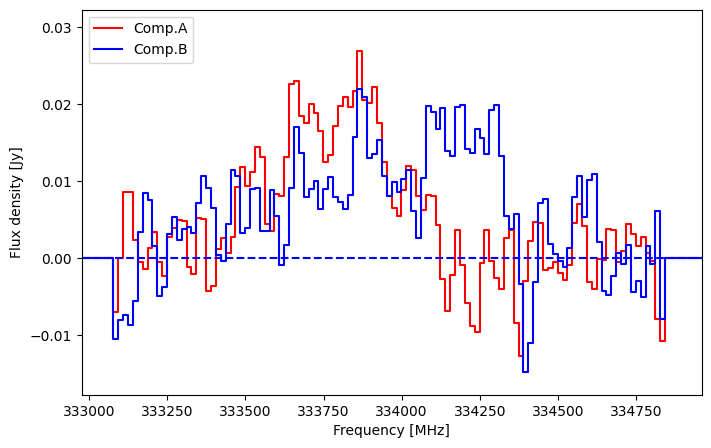

In [24]:
from casatasks import specflux
imname = myimages
radipx = 7 # pixels

# Comp.A (South)
dtext1 = "Comp.A"
splogf1 = imname+'.specA.log'
cetpx1 = [posAx, posAy] # pixs; peak position
specflux(imagename=imname,
     region = 'circle[['+str(cetpx1[0])+'pix,'+str(cetpx1[1])+'pix],'+str(radipx)+'pix]',
     function='flux density', unit='km/s',
     logfile = splogf1, overwrite=True)
dt1_ax,dt1_npx,dt1_frq,dt1_vl,dt1_fl = np.loadtxt(splogf1, comments='#', unpack=True)

# Comp.B (North)
dtext2 = "Comp.B"
splogf2 = imname+'.specB.log'
cetpx2 = [posBx, posBy] # pixs; peak position
specflux(imagename=imname,
     region = 'circle[['+str(cetpx2[0])+'pix,'+str(cetpx2[1])+'pix],'+str(radipx)+'pix]',
     function='flux density', unit='km/s',
     logfile = splogf2, overwrite=True)
dt2_ax,dt2_npx,dt2_frq,dt2_vl,dt2_fl = np.loadtxt(splogf2, comments='#', unpack=True)

imgview=1 # yaxis selection: 0=channel, 1=frequency
dt_flcb = np.r_[dt1_fl, dt2_fl]
ymin = min(dt_flcb); ymax = max(dt_flcb)
ff, aa = plt.subplots(1,1, figsize=(8,5))
if imgview == 0:
    xmin = min(dt1_ax); xmax = max(dt1_ax)
    imr1 = aa.step(dt1_ax, dt1_fl, color="r", label=dtext1, where="mid")
    imr2 = aa.step(dt2_ax, dt2_fl, color="b", label=dtext2, where="mid")
    aa.set_xlim(xmin, xmax)  ; aa.set_xlabel("Channel")
elif imgview == 1:
    xmin = min(dt1_frq); xmax = max(dt1_frq)
    imr1 = aa.step(dt1_frq, dt1_fl, color="r", label=dtext1, where="mid")
    imr2 = aa.step(dt2_frq, dt2_fl, color="b", label=dtext2, where="mid")
    aa.set_xlim(xmin, xmax)  ; aa.set_xlabel("Frequency [MHz]")
aa.set_ylim(ymin*1.2, ymax*1.2) ; aa.set_ylabel("Flux density [Jy]")
plt.hlines([0], xmin, xmax, "blue", linestyles='dashed')
aa.legend(loc="upper left")
plt.savefig('BR1202_line_spectrum2.png', bbox_inches="tight", pad_inches=0.05)
plt.show()

2つの放射成分に対して別々に領域<code>region</code>を指定して、タスク<code><font color='red'>specflux</font></code>で成分ごとの輝線スペクトルを作成して重ねて表示しています。
それぞれの領域<code>region</code>は、前述のタスク<code><font color='red'>imfit</font></code>で算出された中心位置ピクセルを中心に、半径"radipx"ピクセルで指定される円形として指定しています。
成分A（赤）及び成分B（青）の輝線スペクトルは、前述モーメント0マップ上の南側（左下）及び北側（右上）成分に相当します。

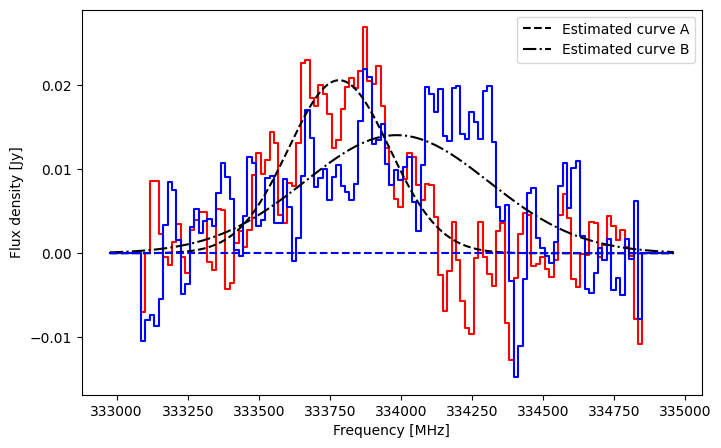

   Estimate   Std.Error
#   Compornent A
A: 0.0205991 +- 0.0011735
mu: 333783.1334890 +- 11.6913284
sigma: 177.7407802 +- 11.6913286
#   Compornent B
A: 0.0140605 +- 0.0011163
mu: 333985.7421253 +- 29.6774033
sigma: 323.7675270 +- 29.7122696


In [25]:
# gaussian function
parm = ["A", "mu", "sigma"]
def gaussian_func(x, A, mu, sigma):
    C = 0.0
    return A * np.exp( - (x - mu)**2 / (2 * sigma**2)) + C

fig, aa = plt.subplots(1,1, figsize=(8,5))

# for Comp.A
x = dt1_frq
y = dt1_fl
# initial_guess_of_parameters
parameter_initial = np.array([0.015, 333750, 500])
popt1, pcov1 = curve_fit(gaussian_func, x, y, p0=parameter_initial)
plt.step(x,y, color="r")
xd1 = np.arange(x.min(), x.max(), 0.01)

# for Comp.B
x = dt2_frq
y = dt2_fl
# initial_guess_of_parameters
parameter_initial = np.array([0.010, 334100, 500])
popt2, pcov2 = curve_fit(gaussian_func, x, y, p0=parameter_initial)
plt.step(x,y, color="b")
xd2 = np.arange(x.min(), x.max(), 0.01)

estimated_curve1 = gaussian_func(xd1, popt1[0], popt1[1], popt1[2])
plt.plot(xd1, estimated_curve1, label="Estimated curve A", color="black", linestyle='dashed')
estimated_curve2 = gaussian_func(xd2, popt2[0], popt2[1], popt2[2])
plt.plot(xd2, estimated_curve2, label="Estimated curve B", color="black", linestyle='dashdot')
aa.legend()
plt.hlines([0], xmin, xmax, "blue", linestyles='dashed')
aa.set_ylabel("Flux density [Jy]"); aa.set_xlabel("Frequency [MHz]")
plt.savefig('BR1202_line_spectrum3.png', bbox_inches="tight", pad_inches=0.05)
plt.show()

StdE1 = np.sqrt(np.diag(pcov1))
StdE2 = np.sqrt(np.diag(pcov2))
print("   Estimate   Std.Error")
print("#   Compornent A")
for prtno in range(len(popt1)):
    print(f'{parm[prtno]}: {popt1[prtno]:.7f} +- {StdE1[prtno]:.7f}')
print("#   Compornent B")
for prtno in range(len(popt2)):
    print(f'{parm[prtno]}: {popt2[prtno]:.7f} +- {StdE2[prtno]:.7f}')

2つの放射成分のそれぞれの輝線スペクトルについてガウシアンフィットを行い、ピークフラックス密度・中心周波数・速度幅の算出を行います。<br>
先にタスク<code><font color='red'>specflux</font></code>で作成されたスペクトルに対して、Pythonのscipyモジュールを使ってモデルフィットを行っています。
ここではガウス関数を以下の様に定義しています。
$$f(x) = A \cdot \exp(\tfrac{-(x - \mu)^2}{2 \, \sigma^2})$$ <!-- + C$$ -->
<!--
f(x) = A &middot; exp( &minus; (x &minus; &#956;)<sup>2</sup> / (2 &#x3C3;<sup>2</sup>)) &plus; C<br>
-->
上式において<b>$A$</b>はガウス関数のピーク値 (Jy)、<b>$\mu$</b> (mu)は(周波数方向の)中心位置 (MHz)、<b>$\sigma$</b> (sigma)は分散 (MHz)を表しています。<br>
なお、スクリプト中の "parameter_initial" に、以下の様にフィッティングの初期値（A, mu, sigma）を入力する必要があります。<br>
<code>parameter_initial = np.array(\[A, mu, sigma\])</code><br>
また、ガウシアンフィットの結果得られたパラメータより、フィッティングカーブを輝線スペクトルと重ねて表示しています。表示されたスペクトルより、フィッティングが適切でない様でしたら初期値を変えて試してみて下さい。

In [26]:
ccc = 299792458*10**-3 # [km/s] : speed of light
rfrq = 1900.539*10**3  # [MHz]  : rest frequency for [CII] line

print("#   Compornent A")
print(f'Center Frequency: {popt1[1]/10**3:.7f} +- {StdE1[1]/10**3:.7f} GHz')
print(f' Redshift (z)   : {rfrq/popt1[1]-1:.7f}')
#print(f' Radio Velocity : {(rfrq-popt1[1])/rfrq*ccc:.7f} km/s')
fwhm1 = 2*popt1[2]*np.sqrt(2*np.log(2))
print(f'Line Width(FWHM): {ccc/popt1[1]*fwhm1:.7f} km/s')

print("#   Compornent B")
print(f'Center Frequency: {popt2[1]/10**3:.7f} +- {StdE2[1]/10**3:.7f} GHz')
print(f' Redshift (z)   : {rfrq/popt2[1]-1:.7f}')
#print(f' Radio Velocity : {(rfrq-popt2[1])/rfrq*ccc:.7f} km/s')
fwhm2 = 2*popt2[2]*np.sqrt(2*np.log(2))
print(f'Line Width(FWHM): {ccc/popt2[1]*fwhm2:.7f} km/s')

#   Compornent A
Center Frequency: 333.7831335 +- 0.0116913 GHz
 Redshift (z)   : 4.6939336
Line Width(FWHM): 375.9249250 km/s
#   Compornent B
Center Frequency: 333.9857421 +- 0.0296774 GHz
 Redshift (z)   : 4.6904794
Line Width(FWHM): 684.3586925 km/s


それぞれ輝線スペクトルへのガウシアンフィットの結果より、輝線の中心周波数 (GHz)及びそこから赤方偏移（redshift: $z$）を算出して表示しています。
赤方偏移は以下の様な式で求めています。
$\nu_{\rm rest}$は静止周波数（rest frequency; ここでは\[CII\]輝線の静止周波数）、$\nu_{\rm obs}$は観測周波数（ここではガウシアンフィットから求められた輝線中心周波数）を表しています。
$$z=\tfrac{\nu_{\rm rest} - \nu_{\rm obs}}{\nu_{\rm obs}}$$
また、ガウシアンフィットで求められた分散（$\sigma$）より、輝線の速度幅（半値全幅: FWHM）(km/s)を算出しています。
ガウス関数の分散（$\sigma$）と半値全幅（FWHM）の関係は ${\rm FWHM}=2\sigma\,\sqrt{2\ln 2}$ の様に表せます。
さらに、周波数幅（$\Delta\nu$）から電波観測における速度幅（$\Delta V_{\rm radio}$）は以下の様に計算しています（マイナスは周波数と速度で正負の向きが逆であることを示す）。
$$\Delta V_{\rm radio} = \tfrac{-\,c}{\nu_{\rm ref}} \Delta\nu_{\rm obs}$$

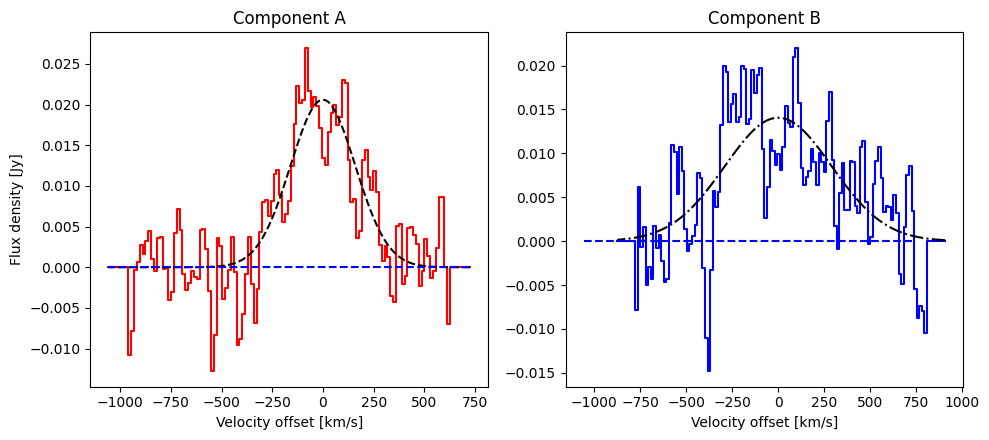

In [27]:
fig,aa = plt.subplots(nrows=1, ncols=2,  figsize=(10,4.5), sharex=False)

vof1 = (popt1[1]-dt1_frq)/popt1[1]*ccc
vec1 = (popt1[1]-xd1)/popt1[1]*ccc
aa[0].step(vof1, dt1_fl, color="r")
aa[0].plot(vec1, estimated_curve1, color="black", linestyle='dashed')

vof2 = (popt2[1]-dt2_frq)/popt2[1]*ccc
vec2 = (popt2[1]-xd2)/popt2[1]*ccc
aa[1].step(vof2, dt2_fl, color="b")
aa[1].plot(vec2, estimated_curve2, color="black", linestyle='dashdot')

aa[0].set_title("Component A",size=12)
aa[1].set_title("Component B",size=12)
aa[0].set_xlabel("Velocity offset [km/s]",size=10)
aa[1].set_xlabel("Velocity offset [km/s]",size=10)
aa[0].set_ylabel("Flux density [Jy]",size=10)
aa[0].hlines([0], min(vof1), max(vof1), "blue", linestyles='dashed')
aa[1].hlines([0], min(vof1), max(vof1), "blue", linestyles='dashed')
plt.tight_layout()
plt.savefig('BR1202_line_spectrum4.png', bbox_inches="tight", pad_inches=0.05)
plt.show()

分かりやすい様に2つの成分それぞれについて別々に、輝線スペクトルをフィッティングカーブと重ねて、中心周波数からのオフセットとして横軸を速度で表示しています。

In [28]:
print("END")

END
